In [1]:
import torch
import numpy as np
from pathlib import Path
import argparse
from neuralop.models import UNO
from magplot.base import create_mesh, mag_plotter
import pyvista as pv
pv.start_xvfb()
pv.set_jupyter_backend('static')

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os
import glob
from sunpy.map import Map
from skimage.transform import resize

from rtmag.test.eval_plot import plot_s

In [2]:
meta_path = Path("/home/usr/workspace/RTNF2/base_new/pino_CC_Hnorm_Unit_2")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [3]:
idx = 360

data_path = "/mnt/f/sdo_AR/NOAA11158_HARP377/hmi"

hmi_p_files = sorted(glob.glob(os.path.join(data_path, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(data_path, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(data_path, '*Br.fits')))  # z

data_paths = list(zip(hmi_p_files, hmi_t_files, hmi_r_files))
data_path = data_paths[idx]
data_path

('/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110215_000000_TAI.Bp.fits',
 '/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110215_000000_TAI.Bt.fits',
 '/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110215_000000_TAI.Br.fits')

In [4]:
hmi_p, hmi_t, hmi_r, = data_path
p_map, t_map, r_map = Map(hmi_p), Map(hmi_t), Map(hmi_r)

maps = [p_map, t_map, r_map]
hmi_data = np.stack([maps[0].data, -maps[1].data, maps[2].data]).transpose()
hmi_data = np.nan_to_num(hmi_data, nan=0.0)
hmi_data = hmi_data.astype(np.float32)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [5]:
hmi_data.shape

(744, 377, 3)

In [6]:
model_input = hmi_data
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4) / b_norm
model_input = torch.from_numpy(model_input).to(device) 
model_input.shape

torch.Size([1, 1, 377, 744, 3])

In [7]:
model_output = model(model_input)

In [8]:
model_output.shape

torch.Size([1, 256, 377, 744, 3])

In [9]:
b = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1)
b = b * divi

In [10]:
b.shape

(744, 377, 256, 3)

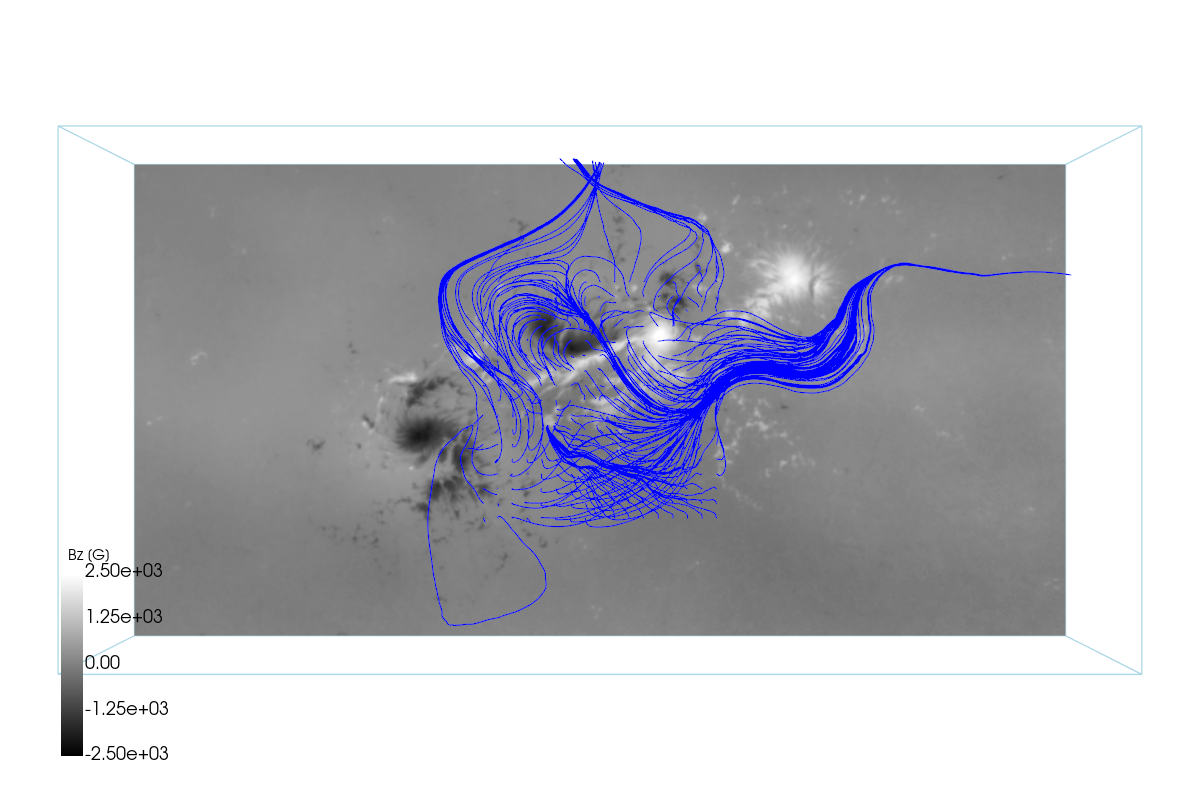

In [11]:
vmin=-2500
vmax=2500
i_siz=b.shape[0] / 4
j_siz=b.shape[1] / 2
i_res=16
j_res=16
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

In [12]:
model_input = resize(hmi_data, (512, 256, 3))
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4) / b_norm
model_input = torch.from_numpy(model_input).to(device) 
model_input.shape

torch.Size([1, 1, 256, 512, 3])

In [13]:
model_output = model(model_input)

In [14]:
model_output.shape

torch.Size([1, 256, 256, 512, 3])

In [15]:
b = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1)
b = b * divi

In [16]:
b.shape

(512, 256, 256, 3)

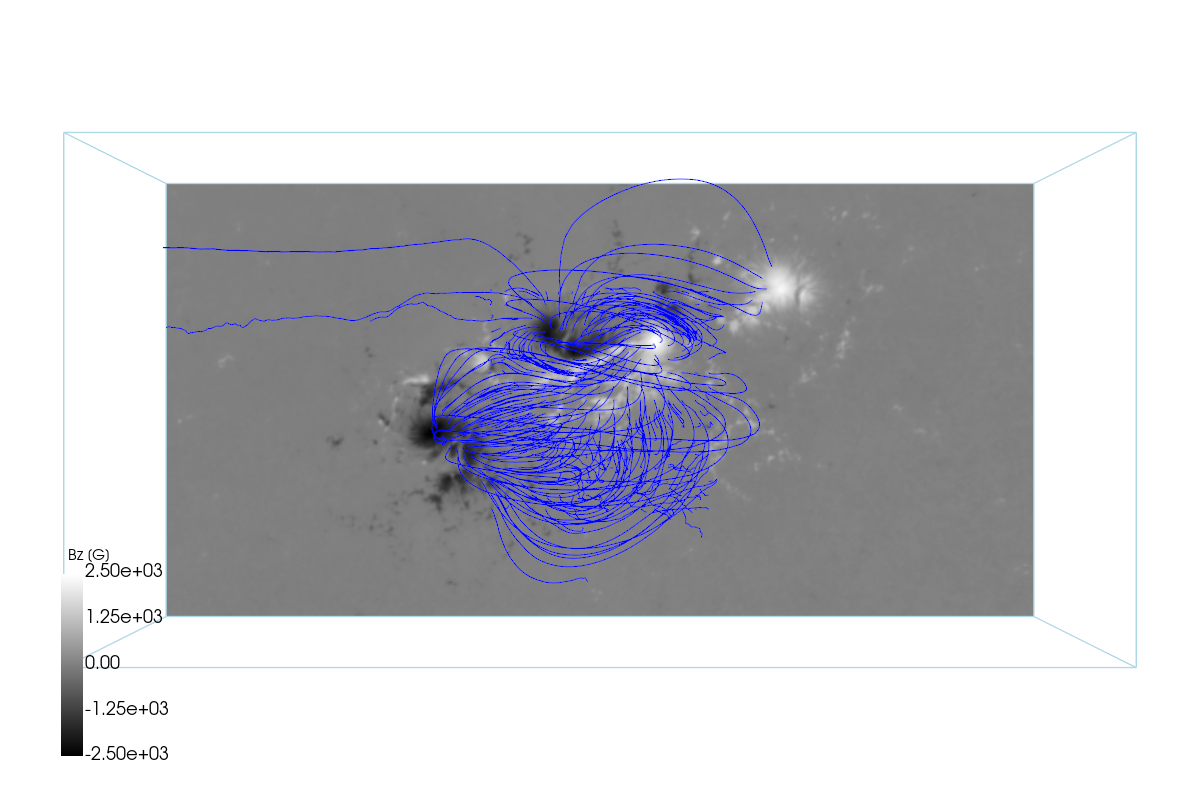

In [17]:
vmin=-2500
vmax=2500
i_siz=b.shape[0] / 4
j_siz=b.shape[1] / 2
i_res=16
j_res=16
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

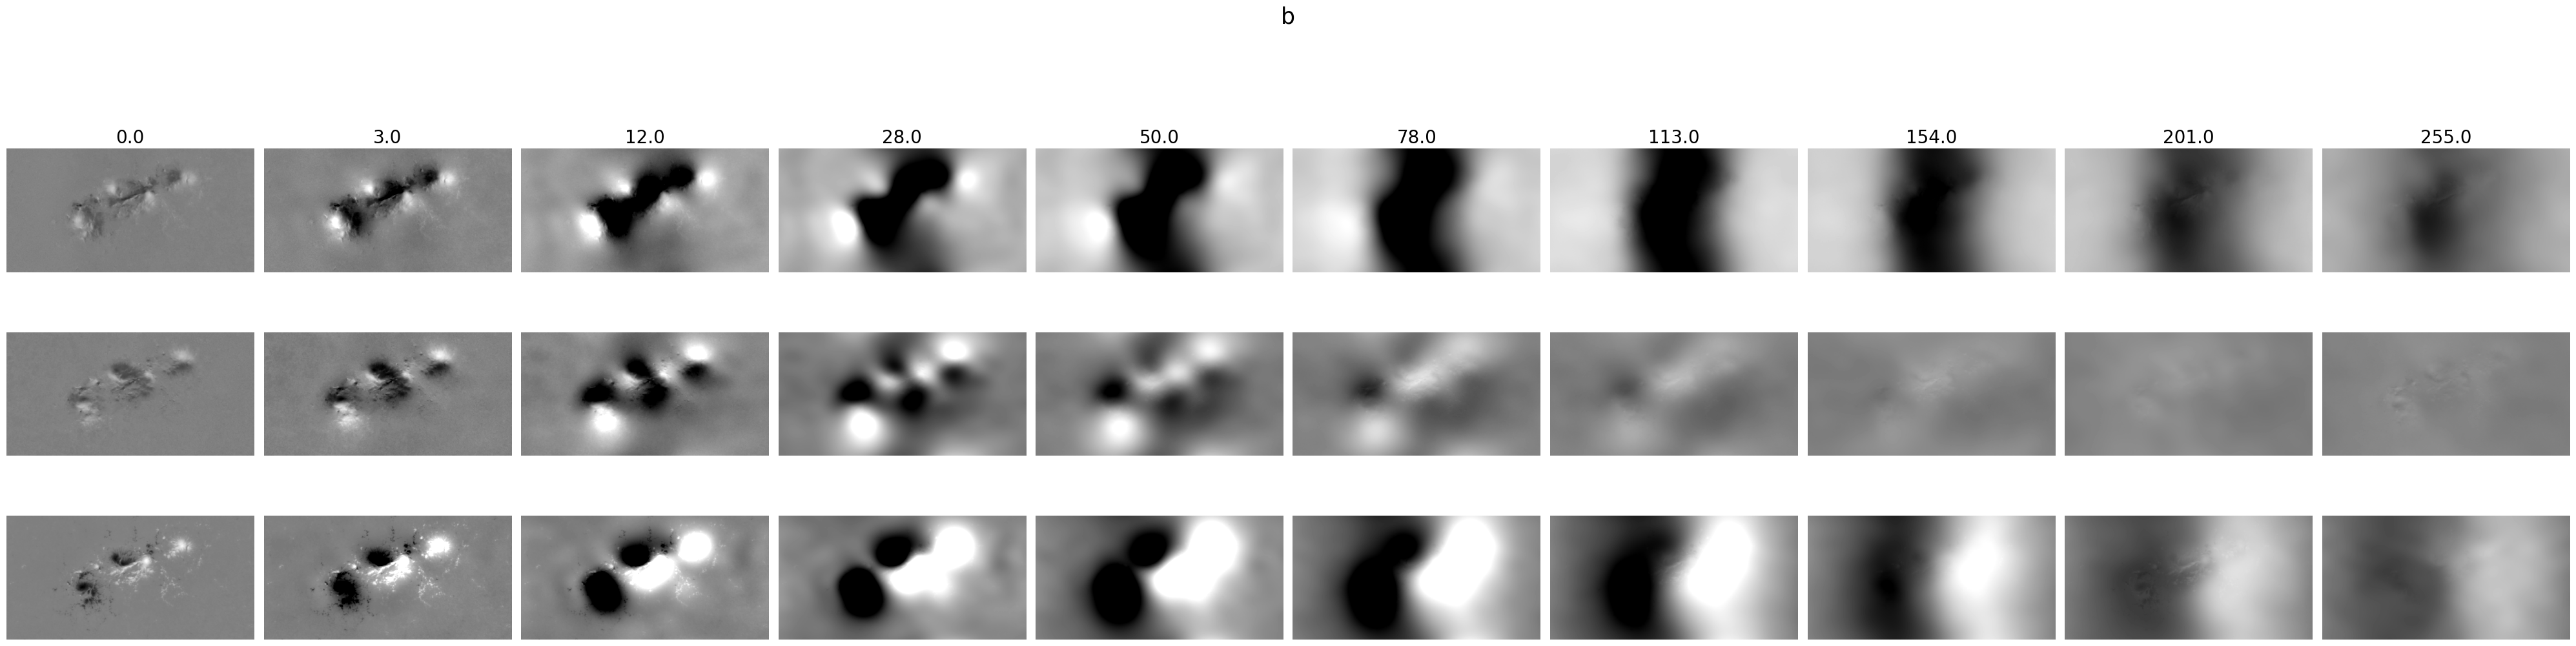

In [19]:
plot_s(b, 'b', n_samples=10, v_mm=2500)